# Poisson regression

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AugmentedGPLikelihoods.jl/blob/main/examples/poisson/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AugmentedGPLikelihoods.jl/dev/examples/poisson/).*

We load all the necessary packages

In [1]:
using AbstractGPs
using ApproximateGPs
using AugmentedGPLikelihoods
using Distributions
using LinearAlgebra

Plotting libraries

In [2]:
using Plots

We create some random data (sorted for plotting reasons)

In [3]:
N = 100
x = range(-10, 10; length=N)
kernel = with_lengthscale(SqExponentialKernel(), 2.0)
gp = GP(kernel)
λ = 5.0
lik = PoissonLikelihood(ScaledLogistic(λ))
lf = LatentGP(gp, lik, 1e-6)
f, y = rand(lf(x));

We plot the sampled data

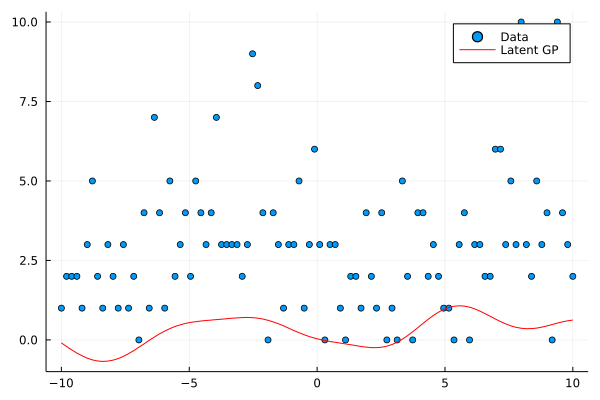

In [4]:
plt = scatter(x, y; label="Data")
plot!(plt, x, f; color=:red, label="Latent GP")

## CAVI Updates
We write our CAVI algorithmm

In [5]:
function u_posterior(fz, m, S)
    return posterior(SparseVariationalApproximation(Centered(), fz, MvNormal(m, S)))
end

function cavi!(fz::AbstractGPs.FiniteGP, x, y, m, S, qΩ; niter=10)
    K = ApproximateGPs._chol_cov(fz)
    for _ in 1:niter
        post_u = u_posterior(fz, m, S)
        post_fs = marginals(post_u(x))
        aux_posterior!(qΩ, lik, y, post_fs)
        S .= inv(Symmetric(inv(K) + Diagonal(only(expected_auglik_precision(lik, qΩ, y)))))
        m .= S * (only(expected_auglik_potential(lik, qΩ, y)) + K \ mean(fz))
    end
    return m, S
end;

Now we just initialize the variational parameters

In [6]:
m = zeros(N)
S = Matrix{Float64}(I(N))
qΩ = init_aux_posterior(lik, N)
fz = gp(x, 1e-8);

And visualize the current posterior

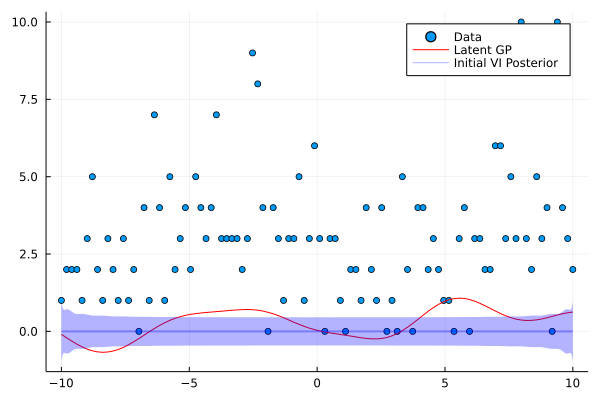

In [7]:
x_te = -10:0.01:10
plot!(
    plt, x_te, u_posterior(fz, m, S); color=:blue, alpha=0.3, label="Initial VI Posterior"
)

We run CAVI for 3-4 iterations

In [8]:
cavi!(fz, x, y, m, S, qΩ; niter=4);

And visualize the obtained variational posterior

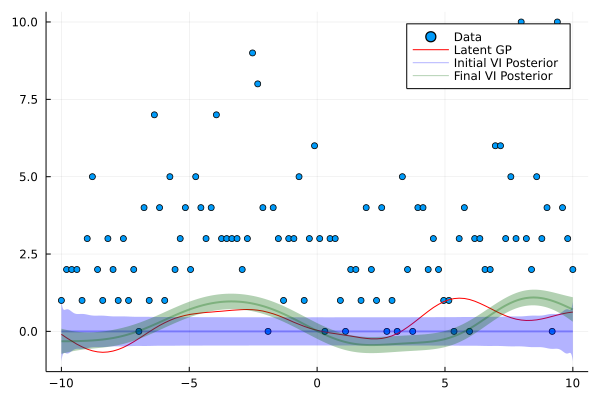

In [9]:
plot!(
    plt,
    x_te,
    u_posterior(fz, m, S);
    color=:darkgreen,
    alpha=0.3,
    label="Final VI Posterior",
)

## ELBO
How can one compute the Augmented ELBO?
Again AugmentedGPLikelihoods provides helper functions
to not have to compute everything yourself

In [10]:
function aug_elbo(lik, u_post, x, y)
    qf = marginals(u_post(x))
    qΩ = aux_posterior(lik, y, qf)
    return expected_logtilt(lik, qΩ, y, qf) - aux_kldivergence(lik, qΩ, y) -
           kldivergence(u_post.approx.q, u_post.approx.fz) # approx.fz is the prior and approx.q is the posterior
end

aug_elbo(lik, u_posterior(fz, m, S), x, y)

-208.75587932272958

## Gibbs Sampling
We create our Gibbs sampling algorithm (we could do something fancier with
AbstractMCMC)

In [11]:
function gibbs_sample(fz, f, Ω; nsamples=200)
    K = ApproximateGPs._chol_cov(fz)
    Σ = zeros(length(f), length(f))
    μ = zeros(length(f))
    return map(1:nsamples) do _
        aux_sample!(Ω, lik, y, f)
        Σ .= inv(Symmetric(inv(K) + Diagonal(only(auglik_precision(lik, Ω, y)))))
        μ .= Σ * (only(auglik_potential(lik, Ω, y)) + K \ mean(fz))
        rand!(MvNormal(μ, Σ), f)
        return copy(f)
    end
end;

We initialize our random variables

In [12]:
f = randn(N)
Ω = init_aux_variables(lik, N);

Run the sampling for default number of iterations (200)

In [13]:
fs = gibbs_sample(fz, f, Ω);

And visualize the samples overlapped to the variational posterior
that we found earlier.

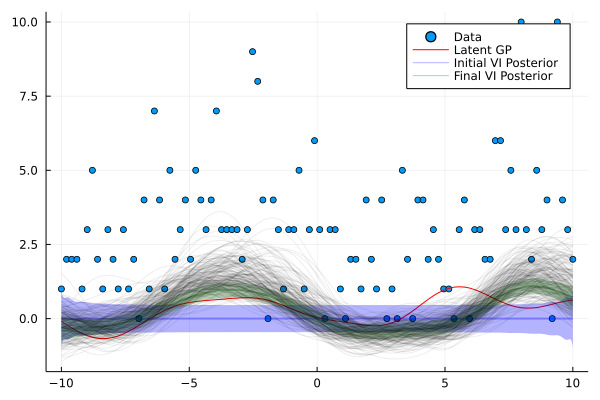

In [14]:
for f in fs
    plot!(plt, x, f; color=:black, alpha=0.07, label="")
end
plt

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
      Status &#96;~/work/AugmentedGPLikelihoods.jl/AugmentedGPLikelihoods.jl/examples/poisson/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.13
  &#91;298c2ebc&#93; ApproximateGPs v0.4.2
  &#91;4689c64d&#93; AugmentedGPLikelihoods v0.4.15 &#96;/home/runner/work/AugmentedGPLikelihoods.jl/AugmentedGPLikelihoods.jl#fd8ebcd&#96;
  &#91;31c24e10&#93; Distributions v0.25.62
  &#91;98b081ad&#93; Literate v2.13.4
  &#91;91a5bcdd&#93; Plots v1.31.1
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.7.3
Commit 742b9abb4d &#40;2022-05-06 12:58 UTC&#41;
Platform Info:
  OS: Linux &#40;x86_64-pc-linux-gnu&#41;
  CPU: Intel&#40;R&#41; Xeon&#40;R&#41; Platinum 8171M CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 &#40;ORCJIT, skylake-avx512&#41;
Environment:
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/fsJ6N/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*